In [1]:
import cv2
import mediapipe as mp
import pandas as pd
from scipy.signal import find_peaks, argrelmin
from scipy.signal import find_peaks, savgol_filter
import matplotlib.pyplot as plt
import numpy as np
import scipy

In [2]:
# Initialize Pose estimator
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

pose = mp_pose.Pose(
    min_detection_confidence=0.6,
    min_tracking_confidence=0.6)

video_path = 'frontal_videos/rear1.avi'

In [3]:
def display_video_with_keypoints(video_path):
    """
    Display the video with detected keypoints and skeleton.

    Parameters:
    - video_path: The path to the video file.

    Returns:
    None
    """

    cap = cv2.VideoCapture(video_path)

    while cap.isOpened():
        _, frame = cap.read()

        try:
            RGB = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            results = pose.process(RGB)

            if results.pose_landmarks is not None:
                keypoints_labels = {
                    mp_pose.PoseLandmark.LEFT_ANKLE: 'LEFT ANKLE',
                    mp_pose.PoseLandmark.RIGHT_ANKLE: 'RIGHT ANKLE',
                }

                for landmark in mp_pose.PoseLandmark:
                    if landmark in keypoints_labels.keys():
                        landmark_index = landmark.value
                        landmark_name = keypoints_labels[landmark]
                        data_point = results.pose_landmarks.landmark[landmark_index]
                        x = data_point.x * frame.shape[1]  # Multiply by width to get x-coordinate in pixels
                        y = data_point.y * frame.shape[0]  # Multiply by height to get y-coordinate in pixels

                        # Draw a label near the keypoint
                        cv2.putText(frame, f"{landmark_name}", (int(x), int(y) - 10),
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)

            # Draw detected skeleton on the frame
            mp_drawing.draw_landmarks(
                frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

            # Show the final output
            cv2.imshow('Output', frame)

        except:
            break

        if cv2.waitKey(1) == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

display_video_with_keypoints(video_path)

In [24]:
def create_dataframe_from_video(video_path):
    """
    Create a DataFrame with coordinates for important keypoints from a video.

    Parameters:
    - video_path: The path to the video file.

    Returns:
    - df: A pandas DataFrame containing keypoint coordinates and additional data.
    """

    cap = cv2.VideoCapture(video_path)

    time = []

    right_ankle_x = []
    right_ankle_y = []

    left_ankle_x = []
    left_ankle_y = []

    right_heel_x = []
    right_heel_y = []

    left_heel_x = []
    left_heel_y = []

    right_knee_x = []
    right_knee_y = []

    left_knee_x = []
    left_knee_y = []

    right_foot_index_x = []
    right_foot_index_y = []

    left_foot_index_x = []
    left_foot_index_y = []

    right_hip_x = []
    left_hip_x = []

    left_shoulder_x = []
    right_shoulder_x = []

    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    print("Frame Height:", frame_height, "pixels\n")

    while cap.isOpened():
        _, frame = cap.read()

        try:
            RGB = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            results = pose.process(RGB)

            if results.pose_landmarks is not None:
                keypoints_labels = {
                    mp_pose.PoseLandmark.LEFT_ANKLE,
                    mp_pose.PoseLandmark.LEFT_KNEE,
                    mp_pose.PoseLandmark.LEFT_HEEL,
                    mp_pose.PoseLandmark.LEFT_FOOT_INDEX,
                    mp_pose.PoseLandmark.LEFT_HIP,
                    mp_pose.PoseLandmark.LEFT_SHOULDER,

                    mp_pose.PoseLandmark.RIGHT_ANKLE,
                    mp_pose.PoseLandmark.RIGHT_KNEE,
                    mp_pose.PoseLandmark.RIGHT_HEEL,
                    mp_pose.PoseLandmark.RIGHT_FOOT_INDEX,
                    mp_pose.PoseLandmark.RIGHT_HIP,
                    mp_pose.PoseLandmark.RIGHT_SHOULDER,
                }

                time.append(cap.get(cv2.CAP_PROP_POS_MSEC))

                for landmark in mp_pose.PoseLandmark:
                    if landmark in keypoints_labels:
                        landmark_index = landmark.value
                        data_point = results.pose_landmarks.landmark[landmark_index]
                        x = data_point.x * frame.shape[1] 
                        y = data_point.y * frame.shape[0]  

                        if landmark == mp_pose.PoseLandmark.RIGHT_ANKLE:
                            right_ankle_x.append(int(x))
                            right_ankle_y.append(int(y))

                        elif landmark == mp_pose.PoseLandmark.LEFT_ANKLE:
                            left_ankle_x.append(int(x))
                            left_ankle_y.append(int(y))

                        elif landmark == mp_pose.PoseLandmark.RIGHT_HEEL:
                            right_heel_x.append(int(x))
                            right_heel_y.append(int(y))

                        elif landmark == mp_pose.PoseLandmark.LEFT_HEEL:
                            left_heel_x.append(int(x))
                            left_heel_y.append(int(y))

                        elif landmark == mp_pose.PoseLandmark.RIGHT_FOOT_INDEX:
                            right_foot_index_x.append(int(x))
                            right_foot_index_y.append(int(y))

                        elif landmark == mp_pose.PoseLandmark.LEFT_FOOT_INDEX:
                            left_foot_index_x.append(int(x))
                            left_foot_index_y.append(int(y))

                        elif landmark == mp_pose.PoseLandmark.RIGHT_HIP:
                            right_hip_x.append(int(x))

                        elif landmark == mp_pose.PoseLandmark.LEFT_HIP:
                            left_hip_x.append(int(x))

                        elif landmark == mp_pose.PoseLandmark.RIGHT_SHOULDER:
                            right_shoulder_x.append(int(x))

                        elif landmark == mp_pose.PoseLandmark.LEFT_SHOULDER:
                            left_shoulder_x.append(int(x))

        except:
            break

        if cv2.waitKey(1) == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

    shoulder_width = (np.array(right_shoulder_x) - np.array(left_shoulder_x)).tolist()
    pelvis = ((np.array(right_hip_x) + np.array(left_hip_x)) / 2).tolist()

    data = {
        'time': np.array(time) / 1000,
        'right_ankle_x': right_ankle_x,
        'right_ankle_y': right_ankle_y,
        'left_ankle_x': left_ankle_x,
        'left_ankle_y': left_ankle_y,
        'right_heel_x': right_heel_x,
        'right_heel_y': right_heel_y,
        'left_heel_x': left_heel_x,
        'left_heel_y': left_heel_y,
        'right_foot_index_x': right_foot_index_x,
        'right_foot_index_y': right_foot_index_y,
        'left_foot_index_x': left_foot_index_x,
        'left_foot_index_y': left_foot_index_y,
        'shoulder_width': shoulder_width,
        'pelvis': pelvis
    }

    df = pd.DataFrame(data)

    df = df[df['time'] > 0] # Remove erroneous initial points
    return df

df = create_dataframe_from_video(video_path)
df.head()


Frame Height: 540 pixels



,time,right_ankle_x,right_ankle_y,left_ankle_x,left_ankle_y,right_heel_x,right_heel_y,left_heel_x,left_heel_y,right_foot_index_x,right_foot_index_y,left_foot_index_x,left_foot_index_y,shoulder_width,pelvis
0,0.08,492,403,472,406,491,415,473,418,489,406,470,410,58,487.5
1,0.12,492,404,472,407,491,417,473,419,495,406,471,408,58,487.5
2,0.16,492,405,472,406,491,417,473,419,497,406,470,408,57,487.5
3,0.20,492,405,472,405,491,418,473,417,498,407,470,408,57,488.5
4,0.24,492,405,472,404,491,418,473,416,498,409,472,405,58,489.0


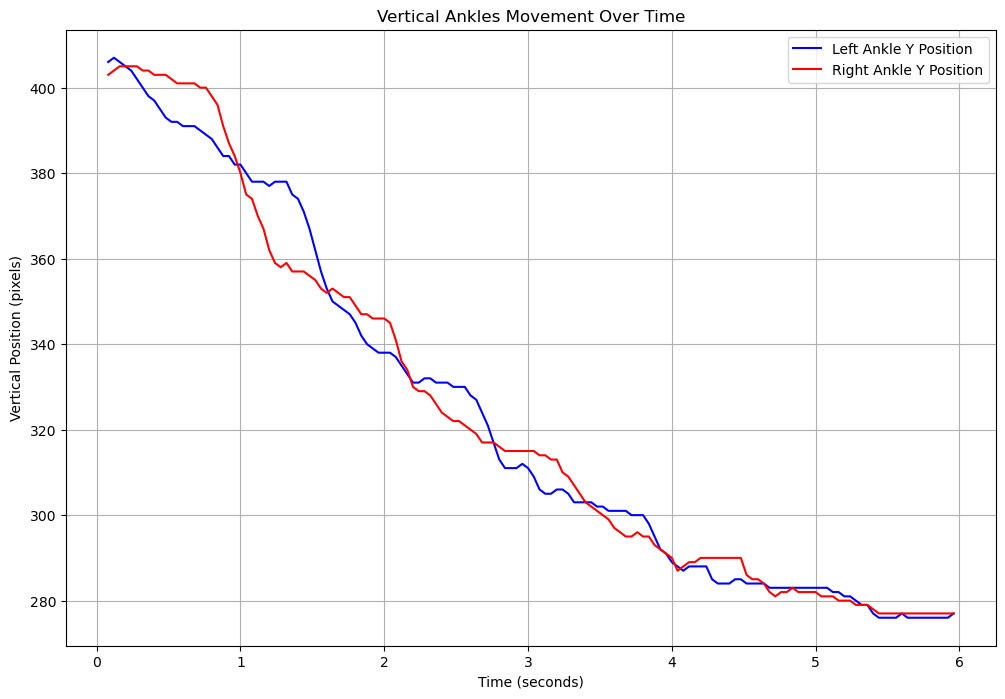

In [25]:
def plot_y_keypoints(time_col, left_ankle_col, right_ankle__col):
    
    plt.figure(figsize=(12, 8))

    plt.plot(time_col, left_ankle_col, label='Left Ankle Y Position', color='blue')
    plt.plot(time_col, right_ankle__col, label='Right Ankle Y Position', color='red')
    
    plt.xlabel('Time (seconds)')
    plt.ylabel('Vertical Position (pixels)')
    plt.title('Vertical Ankles Movement Over Time')
    plt.legend()
    
    plt.grid(True)
    plt.show()

plot_y_keypoints(df['time'], df['left_ankle_y'], df['right_ankle_y'])

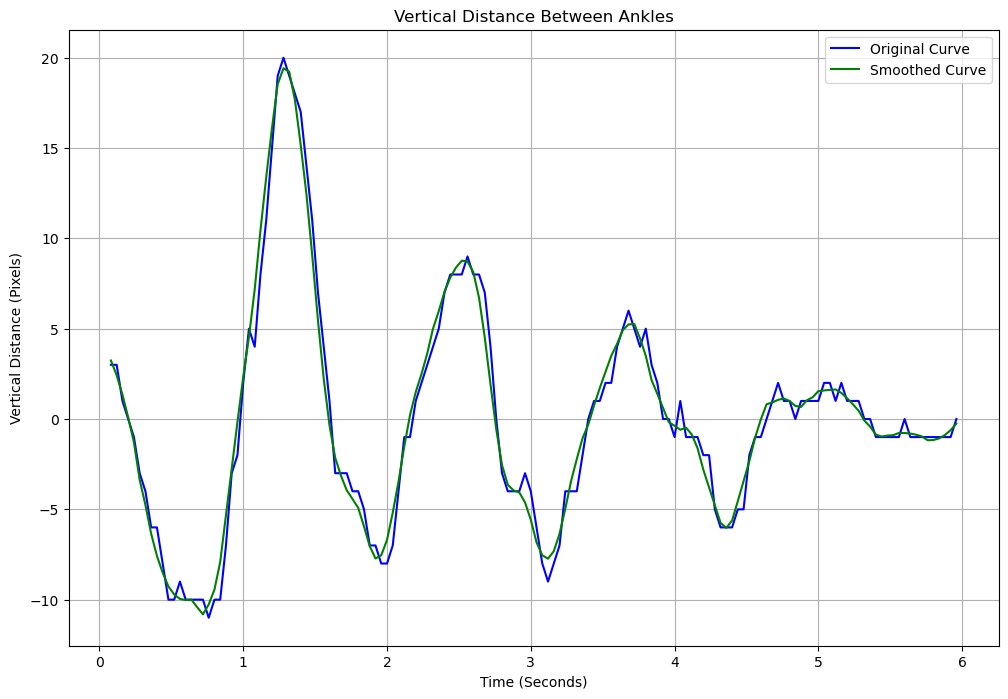

In [26]:
def create_ankle_distance_col(df, window_length, polyorder):
    """
    Calculate and add columns for ankle distance and smoothed ankle distance to a DataFrame.

    Parameters:
    - df: The pandas DataFrame containing the data.
    - window_length: The window size for Savitzky-Golay smoothing.
    - polyorder: The polynomial order for Savitzky-Golay smoothing.

    Returns:
    None (The function modifies the DataFrame in place).
    """
    
    df['vertical_ankle_distance'] = df['left_ankle_y'] - df['right_ankle_y']
    
    # Apply Savitzky-Golay smoothing 
    smoothed_distance = savitzky_golay_smoothing(df['vertical_ankle_distance'].values, window_length, polyorder)
    df['smoothed_vertical_ankle_distance'] = smoothed_distance
    
    plot_orginal_smoothed_curves(df['time'], df['vertical_ankle_distance'], df['smoothed_vertical_ankle_distance'])
    
def savitzky_golay_smoothing(data, window_size, polynomial_order):
        """
        Apply Savitzky-Golay smoothing to the data.

        Parameters:
        - data: The data to be smoothed.
        - window_size: The window size for smoothing.
        - polynomial_order: The polynomial order for smoothing.

        Returns:
        - smoothed_data: The data after Savitzky-Golay smoothing.
        """
        
        return savgol_filter(data, window_size, polynomial_order)

def plot_orginal_smoothed_curves(time_col, original_col, smoothed_col):
    
    plt.figure(figsize=(12, 8))

    plt.plot(time_col, original_col, label='Original Curve', color='blue')
    plt.plot(time_col, smoothed_col, label='Smoothed Curve', color='green')
    
    plt.xlabel('Time (Seconds)')
    plt.ylabel('Vertical Distance (Pixels)')
    plt.title("Vertical Distance Between Ankles")
    plt.legend()
    
    plt.grid(True)
    plt.show()

window_length = 10
polyorder = 3
create_ankle_distance_col(df, window_length, polyorder)


In [27]:
def find_maxima(time_col, ankle_distance_col, window_size):
    """
    Find local maxima in a curve.

    Parameters:
    - time_col: A pandas Series containing time values.
    - ankle_distance_col: A pandas Series representing the distance between ankles.
    - window_size: The width parameter for peak detection.

    Returns:
    - maxima: A NumPy array containing (time, value) pairs for the maxima.
    """
    max_peaks, _ = find_peaks(ankle_distance_col.values, width=window_size)
    max_times = time_col.iloc[max_peaks].values
    max_vals = ankle_distance_col.iloc[max_peaks].values
    maxima = np.column_stack((max_times, max_vals))
    return maxima

def find_minima(time_col, ankle_distance_col, window_size):
    """
    Find local minima in a curve.

    Parameters:
    - time_col: A pandas Series containing time values.
    - ankle_distance_col: A pandas Series representing the distance between ankles.
    - window_size: The width parameter for peak detection.

    Returns:
    - minima: A NumPy array containing (time, value) pairs for the minima.
    """
    min_peaks, _ = find_peaks(-ankle_distance_col.values, width=window_size)
    min_times = time_col.iloc[min_peaks].values
    min_vals = ankle_distance_col.iloc[min_peaks].values
    minima = np.column_stack((min_times, min_vals))
    return minima

def graph_extrema(times, curve, left_heel_strikes, right_heel_strikes):
    plt.figure(figsize=(10, 6))

    plt.plot(times, curve, color='b')

    # Plot the maxima and minima on the original curve
    plt.plot(left_heel_strikes[:, 0], left_heel_strikes[:, 1], 'ro', label='Maxima', markersize=5)
    plt.plot(right_heel_strikes[:, 0], right_heel_strikes[:, 1], 'go', label='Minima', markersize=5)

    plt.xlabel('Time (Seconds)')
    plt.ylabel('Vertical Distance between Ankles (Pixels)')
    plt.title('Vertical Distance Between Ankles over Time')
    plt.legend()
    plt.grid(True)

    plt.show()


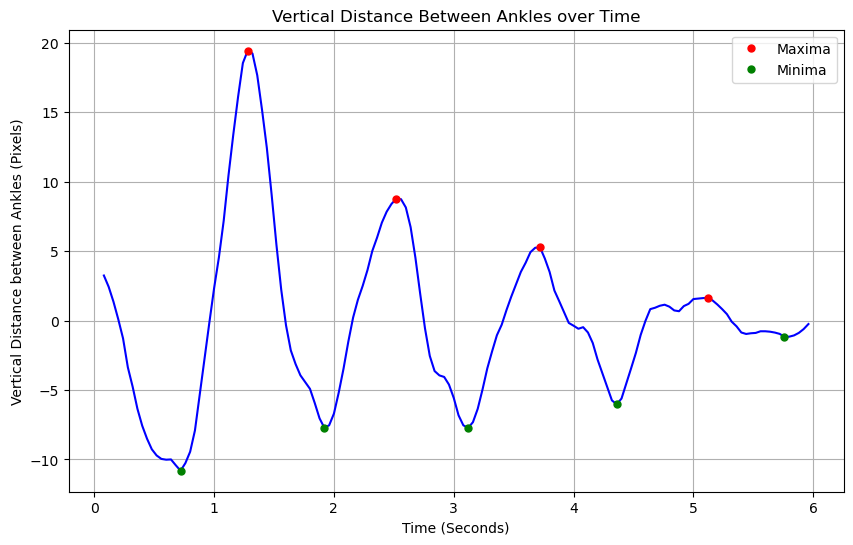

Left Heel Strikes:
 [[ 1.28    19.41875]
 [ 2.52     8.7625 ]
 [ 3.72     5.25625]
 [ 5.12     1.6375 ]]

Right Heel Strikes:
 [[  0.72    -10.8125 ]
 [  1.92     -7.71875]
 [  3.12     -7.73125]
 [  4.36     -6.03125]
 [  5.76     -1.175  ]]


In [28]:
window_size = 5
time_col = df['time']
ankle_distance_col = df['smoothed_vertical_ankle_distance']
left_heel_strikes = find_maxima(time_col, ankle_distance_col, window_size)
right_heel_strikes = find_minima(time_col, ankle_distance_col, window_size)
graph_extrema(time_col, ankle_distance_col, left_heel_strikes, right_heel_strikes)

print("Left Heel Strikes:\n", left_heel_strikes)
print("\nRight Heel Strikes:\n", right_heel_strikes)


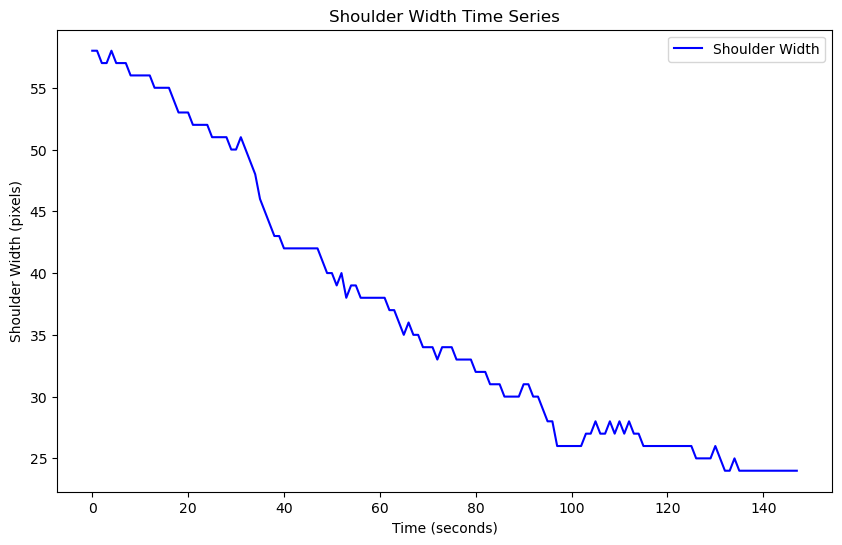

In [29]:
def replace_outliers(df, column_name, threshold=2):
    """
    Replace outliers in a DataFrame column with the previous value if the distance between consecutive points exceeds the threshold.

    Parameters:
    - df: The pandas DataFrame containing the keypoint positions
    - column_name: The name of the column in which outliers should be replaced.
    - threshold: The threshold for replacing outliers.

    Returns:
    - A modified DataFrame with outliers replaced.
    """
    data = df[column_name].copy()
    for i in range(1, len(data)):
        if abs(data[i] - data[i - 1]) > threshold:
            data[i] = data[i - 1]
    df[column_name] = data

def graph_shoulder_width(time_col, shoulder_col):
    shoulder_width = df['shoulder_width']
    
    fig, ax = plt.subplots(figsize=(10, 6))  
    
    ax.plot(shoulder_width, label='Shoulder Width', color='blue')
    
    ax.set_xlabel('Time (seconds)')  
    ax.set_ylabel('Shoulder Width (pixels)')         
    ax.set_title('Shoulder Width Time Series')     
    ax.legend()                           
    
    plt.show()

replace_outliers(df, 'shoulder_width', threshold=2)
graph_shoulder_width(df['time'], df['shoulder_width'])

In [30]:
def calc_step_time(arr):
    """
    Calculate the mean and standard deviation of time between consecutive points in an array.

    Parameters:
    - arr: A 2D NumPy array where the first column represents time values.

    Returns:
    - mean: The mean time difference between consecutive points.
    - std: The standard deviation of time differences between consecutive points.
    """
    time_dif = []

    for i in range(0, len(arr) - 1):
        dif = arr[i + 1, 0] - arr[i, 0]
        time_dif.append(dif)

    np_time_dif = np.array(time_dif)
    mean = np.mean(np_time_dif)
    std = np.std(np_time_dif)

    return mean, std

def get_step_time(left_heel_strike, right_heel_strike):
    """
    Calculate the step time between consecutive bilateral heel-strikes.

    Parameters:
    - left_heel_strike: A 2D NumPy array representing left heel-strike data.
    - right_heel_strike: A 2D NumPy array representing right heel-strike data.

    Returns:
    - left_step_mean: The mean step time for left heel-strikes.
    - left_step_std: The standard deviation of step time for left heel-strikes.
    - right_step_mean: The mean step time for right heel-strikes.
    - right_step_std: The standard deviation of step time for right heel-strikes.
    """
    left_step_mean, left_step_std = calc_step_time(left_heel_strike)
    right_step_mean, right_step_std = calc_step_time(right_heel_strike)
    
    return left_step_mean, left_step_std, right_step_mean, right_step_std
    
get_step_time(left_heel_strikes, right_heel_strikes)

(1.28, 0.08640987597877138, 1.26, 0.08246211251235294)

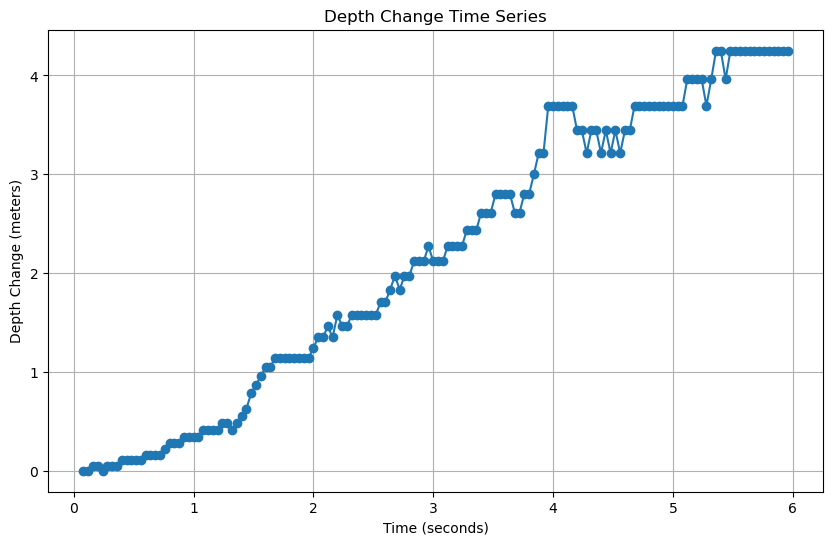

In [31]:
def calc_depth_time_series(df, starting_distance):
    """
    Calculate a depth change time series based on shoulder width data.

    Parameters:
    - df: A pandas DataFrame containing shoulder width data.
    - starting_distance: The initial distance (in meters) from the camera to the subject.

    Returns:
    - depth_change_series: A list of depth change values (in meters) over time.
    """
    initial_pixel_width = df['shoulder_width'].iloc[0] # Initial shoulder width in pixels

    depth_change_series = []
    for pixel_width in df['shoulder_width']:
        depth_change = starting_distance * initial_pixel_width / pixel_width - starting_distance
        depth_change_series.append(depth_change)
    
    return depth_change_series

def graph_depth_time_series(time_col, depth_change_col):
    plt.figure(figsize=(10, 6))
    plt.plot(time_col, depth_change_col, marker='o')
    plt.title('Depth Change Time Series')
    
    plt.xlabel('Time (seconds)')
    plt.ylabel('Depth Change (meters)')
    
    plt.grid(True)
    plt.show()

starting_distance = 3 # distance from camera (meters)
depth_change_series = calc_depth_time_series(df, starting_distance)
graph_depth_time_series(df['time'], depth_change_series)
